Pada pertemuan kali ini, kita akan membahas beberapa hal, diantaranya :
1. How to Improve Model Performance
2. Feature Engineering
3. Pipeline
4. Cross-Validation
5. Hyperparameter Tuning, etc.

# 1. Import Library

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 2. Extract & EDA (Exploratory Data Analysis)

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Course Files/Course-Net/02. Kampus Merdeka/03. Classification/titanic.csv')

## 2.1. Univariate Analysis

<Axes: xlabel='Survived', ylabel='count'>

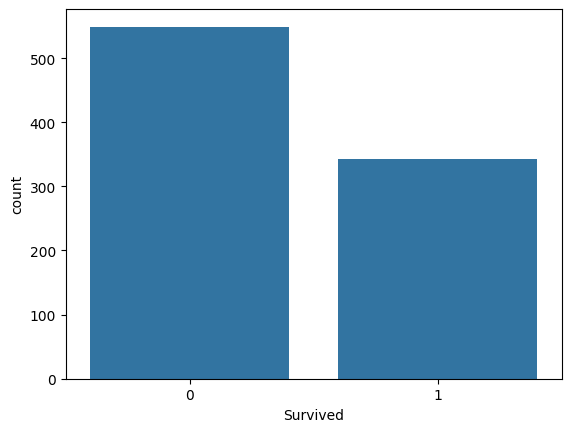

In [5]:
sns.countplot(data=df,x='Survived')

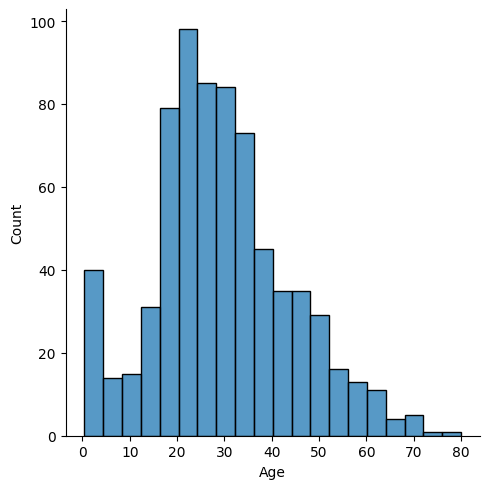

In [6]:
sns.displot(data=df,x='Age')

Mayoritas penumpang berada di usia 20-40.

## 2.2. Bivariate Analysis

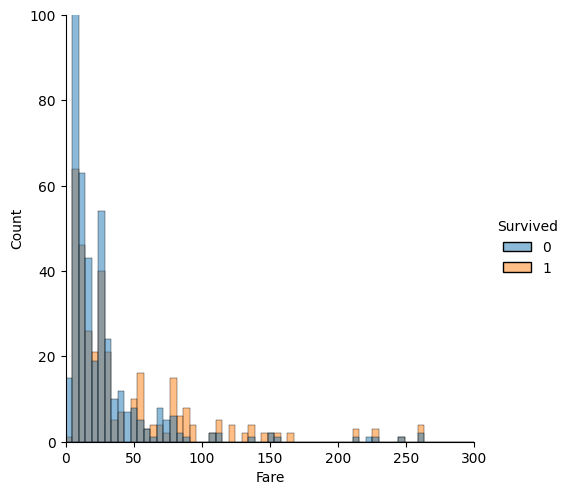

In [9]:
sns.displot(data=df,x='Fare', hue='Survived')
plt.xlim([0,300])
plt.ylim([0,100])
plt.show()

Semakin mahal harga tiket, semakin besar kemungkinan untuk selamat.

<Axes: xlabel='SibSp', ylabel='count'>

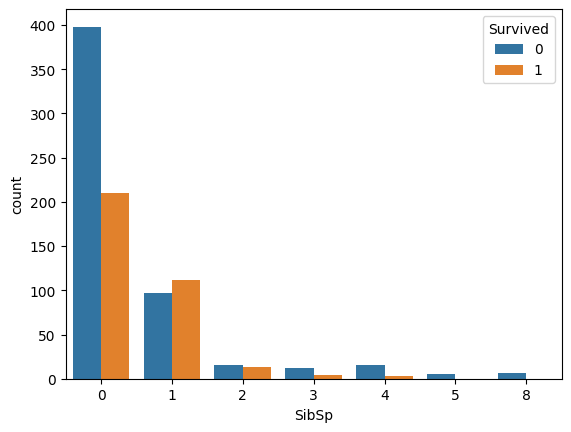

In [11]:
sns.countplot(data=df,x='SibSp',hue="Survived")

Jika hanya berdua, kemungkinan untuk selamatnya besar.

# 3. Feature Engineering

## 3.1. Feature Addition by Crossing

In [12]:
df['is_pair'] = df['SibSp'].apply(lambda x : 1 if x == 1 else 0)

## 3.2. Type Conversion : Decoding (Numerik - Kategorikal) Age

In [15]:
age_binning  = [0,5,12,17,45,70,100]
age_category = ['balita','anak-anak','remaja','dewasa','orangtua','lansia']

df['age_category'] = pd.cut(df['Age'],bins=age_binning,labels=age_category)

# 4. Data Splitting

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X = df.drop(columns=['Survived'])
y = df.Survived

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

# 5. Pipeline
Preprocessing - Modeling

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler, PowerTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [31]:
num_preprocessor = Pipeline([("num_imputer",SimpleImputer(strategy='median')),
                             ("num_scaler",MinMaxScaler())])

cat_preprocessor = Pipeline([("cat_imputer",SimpleImputer(strategy='most_frequent')),
                             ("cat_encoder",OneHotEncoder())])

num_columns = ['Age','Fare','Parch','SibSp']
cat_columns = ['Sex','Embarked','is_pair','age_category','Pclass']

preprocessor = ColumnTransformer([("num_pipeline",num_preprocessor,num_columns),
                                  ("cat_pipeline",cat_preprocessor,cat_columns)])


complete_pipeline = Pipeline([("preprocess",preprocessor),
                              ("model",KNeighborsClassifier())])

In [38]:
from sklearn import set_config
set_config(display=None)

complete_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Fare', 'Parch',
                                                   'SibSp']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'Embarked', 'is_pair',
                                                   'age_category',
                                                   'Pclass'])])),
                ('model', KNeighborsClassifier())])

In [33]:
model = complete_pipeline.fit(X_train,y_train)

In [37]:
model.score(X_train,y_train),model.score(X_test,y_test)

(0.8525280898876404, 0.7932960893854749)

# 6. Training Model by Hyperparameter Tuning

In [40]:
# complete_pipeline.get_params()

In [63]:
parameter_grid ={
    'model__n_neighbors' : np.arange(5,20),         # ada 15 item
    'model__weights' : ['uniform','distance']       # ada 2 item
}

## ada sebanyak 15x2 = 30 kombinasi hyperparameter

In [46]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## 5.1. GridSearchCV
semua kombinasi hyperparameter akan dicoba

In [64]:
model_gscv = GridSearchCV(estimator=complete_pipeline,
                          param_grid=parameter_grid,
                          cv=5,
                          verbose=1)

model_gscv.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('num_scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Age',
                                                                          'Fare',
                                                                          'Parch',
                                                                          'SibSp']),
                                                                        ('cat_pipeline',
                                                                         Pipeline(steps=[('cat_imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('cat_encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex',
                                                                          'Embarked',
                                                                          'is_pair',
                                                                          'age_category',
                                                                          'Pclass'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                         'model__weights': ['uniform', 'distance']},
             verbose=1)

In [55]:
# pd.DataFrame(model_gscv.cv_results_)

In [52]:
model_gscv.best_params_

{'model__n_neighbors': 10, 'model__weights': 'uniform'}

## 5.2. RandomizedSearchCV
memakai beberapa kombinasi saja

In [60]:
model_rscv = RandomizedSearchCV(estimator=complete_pipeline,
                                param_distributions=parameter_grid,
                                cv=5,
                                verbose=1,
                                random_state=42)

model_rscv.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('num_imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('num_scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['Age',
                                                                                'Fare',
                                                                                'Parch',
                                                                                'SibSp']),
                                                                              ('cat_pipeline',
                                                                               Pipeline(steps=[('cat_imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('cat_encoder',
                                                                                                OneHotEncoder())]),
                                                                               ['Sex',
                                                                                'Embarked',
                                                                                'is_pair',
                                                                                'age_category',
                                                                                'Pclass'])])),
                                             ('model',
                                              KNeighborsClassifier())]),
                   param_distributions={'model__n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                                        'model__weights': ['uniform',
                                                           'distance']},
                   random_state=42, verbose=1)

# 7. Model Performance

In [57]:
from sklearn.metrics import classification_report

def model_performance(model):
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)
    print('Model Performance on Data Training')
    print(classification_report(y_train,y_train_pred))

    print('Model Performance on Data Testing')
    print(classification_report(y_test,y_test_pred))

In [58]:
model_performance(model_gscv)

Model Performance on Data Training
              precision    recall  f1-score   support

           0       0.82      0.94      0.87       439
           1       0.87      0.66      0.75       273

    accuracy                           0.83       712
   macro avg       0.84      0.80      0.81       712
weighted avg       0.83      0.83      0.82       712

Model Performance on Data Testing
              precision    recall  f1-score   support

           0       0.76      0.88      0.82       110
           1       0.75      0.57      0.64        69

    accuracy                           0.76       179
   macro avg       0.76      0.72      0.73       179
weighted avg       0.76      0.76      0.75       179

